# Name of UQ Method

## Theoretic Foundation

As for DKL, DUE provides uncertainty estimates in a **single** forward pass.
DUE builds on DKL and addresses its limitations. Examining why DKL uncertainty underperforms, we find that for certain feature extractors, data points dissimilar to the training data (also called *out-of-distribution* or *OoD data*) might be mapped closed to feature representations of in-distribution points.

This is called *feature collapse*, and suggests that a constraint must be placed on the deep feature extractor.
To understand what constraints must be placed on the DKL feature extractor, we take inspiration from [DUQ](https://arxiv.org/abs/2003.02037) and [SNGP](https://arxiv.org/abs/2006.10108) which propose to use a bi-Lipschitz constraint on a feature extractor in the context of radial basis function (RBF) networks and an RFF GP.
This constraint enforces the feature representation to be sensitive to changes in the input (lower Lipschitz, avoids feature collapse) but also generalize due to smoothness (upper Lipschitz).

### Claimed advantages of DUE - compared to alternative single forward pass uncertainty methods

- DUQ's one-vs-all loss cannot be extended to regression, while DUE is demonstrated to work well on both classification and regression.
- SNGP uses the RFF approximation, which means the uncertainty concentrates in the limit of data, even *far-away* from the training data.
- in contrast to SNGP, DUE's inducing point GP preserves the exact GP's properties and has similar uncertainty outside the support of the training data when trained on small and very large datasets.
-  In contrast to existing DKL methods, DUE avoids feature collapse (due to the approximate bi-Lipshitz constraint), and training DUE is substantially simplified: no pre-training is necessary and there is no computational overhead over a standard softmax model.

### Enforcing Bi-Lipshitz continuity of the feature extractor DNN

DUE builds on the foundation of [GPDNN](https://arxiv.org/abs/1707.02476):

- to enforce the bi-Lipschitz constraint and enable high quality uncertainty, we restrict the deep feature extractor to have residual connections in combination with spectral normalization
- decrease the risk of feature collapse: the GP output is placed directly on top of the last convolutional layer of a large model, which is 640 dimensional in the case of the WRN.

### Spectral Normalization  

- Online power iteration for spectral normalization can be implemented exactly for fully connected layers and 1x1 convolutions.
- For convolutions larger than 1x1, we use an approximate method that lower bounds the exact method, as proposed in \citet{gouk2021regularisation} and implemented by \citet{behrmann2019invertible}.

### Model Definition

Let $X \in \mathbb{R}^{N \times D}$ and $Y \in \mathbb{R}^{N}$ be a dataset of $N$ points with input dimensionality $D$ and output dimensionality $1$. \textcolor{blue}{In the paper the output is $T$ dimensional, for simplicity in the following we set $T=1$.}
$F \in  \mathbb{R}^{N}$ are the values of the underlying noiseless function the GP is modelling, so here $F(x) \sim y(x)$.
The model is formed of an independent GP for each output dimension, in our case one.
The joint distribution over $Y$ and $F$, evaluated at inputs $X$, is

\begin{align}
  p(Y, F; X)      & = p(Y | F) p(F; X) \\
  p(F; X) & = \text{GP}(\mu(X), k_{l, \bm{w}}(X, X)).
\end{align}

Here $\mu(\cdot)$ is a mean function and we use a constant mean function $\mu(X) = \mu$, where $\mu$ is a hyperparameter.
$k_{l, \bm{w}}(\cdot, \cdot)$ is a deep kernel function with feature extractor parameters $\bm{w}$, as described for DKL, and base kernel $\bar{k}_{l}(\cdot, \cdot)$ with hyperparameter $l$ shared for each input dimension.
$p(Y | F)$ is the likelihood function.
For regression tasks this is defined $p(Y | F) = \prod_{i=1}^N \mathcal{N}(Y_{i} | F, \sigma^2)$, where $\sigma^2$ is a variance hyparameter.

Exact inference is possible for the regression case, the computational complexity scales cubically with the number of data points, thus it is not suitable for large datasets. Thus we use a sparse GP approximation and variational inference.

### Summary of learnable parameters
- weights of DNN feature extractor $\bm{w}$
- for the GP, parameters $\theta$: noise hyperparamter $\sigma^2$, the GP function mean $\mu$, the length scale of the GP kernel $l$. In the above case the GP hyperparameters are learned by optimizing ELBO.

### Summary of hyperparameters
- number of power iterations for spectral normalization, usually set to $r=1$
- number of initial inducing points $M$, e.g. for toy regression, we use $20$ inducing points and for two moons we use four
-  the GP noise hyperparamter $\sigma^2$, the GP function mean $\mu$, the length scale of the GP kernel $l$. In the above case the GP hyperparameters are learned by optimizing ELBO. \textcolor{blue}{if we have problems maybe we can choose these before?}
-  in the following example for univariate regression, we have $T=1$ and thus there are only three GP hyperparameters above
-  choice of variational posterior for ELBO, $q(U) =  \mathcal{N}(U | \bm{m}, S)$, where $m = \bm{0}$ and $S$ is chosen as the $M\times M$ identity matrix


## Imports

In [1]:
import os
import sys

# required to make the path visible to import the tools
# this will change in public notebooks to be "pip install uq-regression-box"
nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
nb_dir

import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from gpytorch.mlls import VariationalELBO
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from uq_method_box.datamodules import ToyHeteroscedasticDatamodule
from uq_method_box.models import MLP
from uq_method_box.uq_methods import DUEModel, DKLGPLayer
from uq_method_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions,
    plot_toy_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]



In [2]:
seed_everything(0)  # seed everything for reproducibility

Global seed set to 0


0

We define a temporary directory to look at some training metrics and results.

In [3]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

To demonstrate the method, we will make use of a Toy Regression Example that is defined as a [Lightning Datamodule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). For DUE it is important to use a batch size smaller than the dataset size, so we will choose 50.

In [20]:
dm = ToyHeteroscedasticDatamodule(batch_size=50)

X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

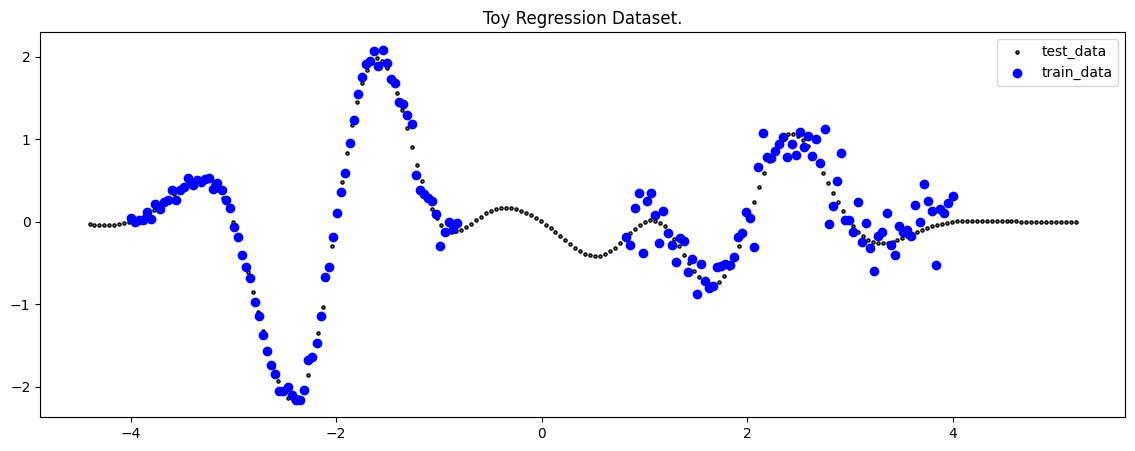

In [21]:
plot_toy_data(X_train, y_train, X_test, y_test)

## Model

For our Toy Regression problem, we will use a simple Multi-layer Perceptron (MLP) that you can configure to your needs. For the documentation of the MLP see [here](https://torchgeo.readthedocs.io/en/stable/api/models.html#MLP).

In [32]:
feature_extractor = MLP(
    n_inputs=1, n_outputs=10, n_hidden=[100], activation_fn=torch.nn.ReLU()
)
feature_extractor

MLP(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=100, out_features=10, bias=True)
  )
)

With an underlying neural network, we can now use our desired UQ-Method as a sort of wrapper. All UQ-Methods are implemented as [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) that allow us to concisely organize the code and remove as much boilerplate code as possible.

In [33]:
due_model = DUEModel(
    feature_extractor=feature_extractor,
    gp_layer=partial(DKLGPLayer, n_outputs=1, kernel="RBF"),
    elbo_fn=partial(VariationalELBO),
    optimizer=partial(torch.optim.Adam, lr=1e-2),
    train_loader=train_loader,
    n_inducing_points=50,
    save_dir=my_temp_dir
)

## Trainer

Now that we have a LightningDataModule and a UQ-Method as a LightningModule, we can conduct training with a [Lightning Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html). It has tons of options to make your life easier, so we encourage you to check the documentation.

In [34]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=500,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training our model is now easy:

In [35]:
trainer.fit(due_model, dm)  # (uq_method, dm)


  | Name              | Type               | Params
---------------------------------------------------------
0 | feature_extractor | MLP                | 1.2 K 
1 | train_metrics     | MetricCollection   | 0     
2 | val_metrics       | MetricCollection   | 0     
3 | test_metrics      | MetricCollection   | 0     
4 | gp_layer          | DKLGPLayer         | 3.1 K 
5 | scale_to_bounds   | ScaleToBounds      | 0     
6 | likelihood        | GaussianLikelihood | 1     
7 | elbo_fn           | VariationalELBO    | 3.1 K 
---------------------------------------------------------
4.3 K     Trainable params
0         Non-trainable params
4.3 K     Total params
0.017     Total estimated model params size (MB)
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argume

## Training Metrics

To get some insights into how the training went, we can use the utility function to plot the training loss and RMSE metric.

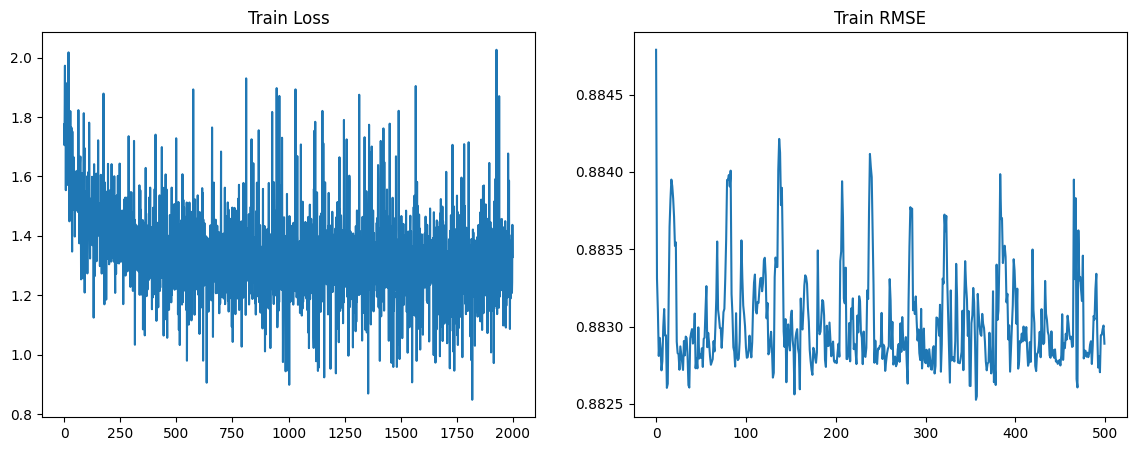

In [36]:
fig = plot_training_metrics(my_temp_dir)

## Prediction

In [27]:
preds = due_model.predict_step(X_test)

## Evaluate Predictions

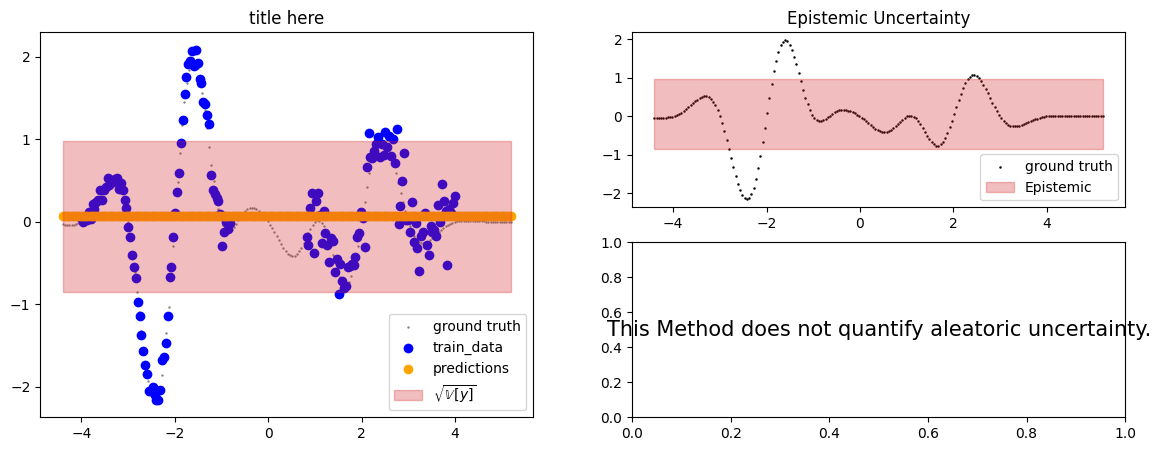

In [28]:
fig = plot_predictions(
    X_train,
    y_train,
    X_test,
    y_test,
    preds["mean"],
    preds["pred_uct"],
    epistemic=preds["epistemic_uct"],
    title="title here",
)

For some additional metrics relevant to UQ, we can use the great [uncertainty-toolbox](https://uncertainty-toolbox.github.io/) that gives us some insight into the calibration of our prediction. For a discussion of why this is important, see ...

<Figure size 1400x500 with 0 Axes>

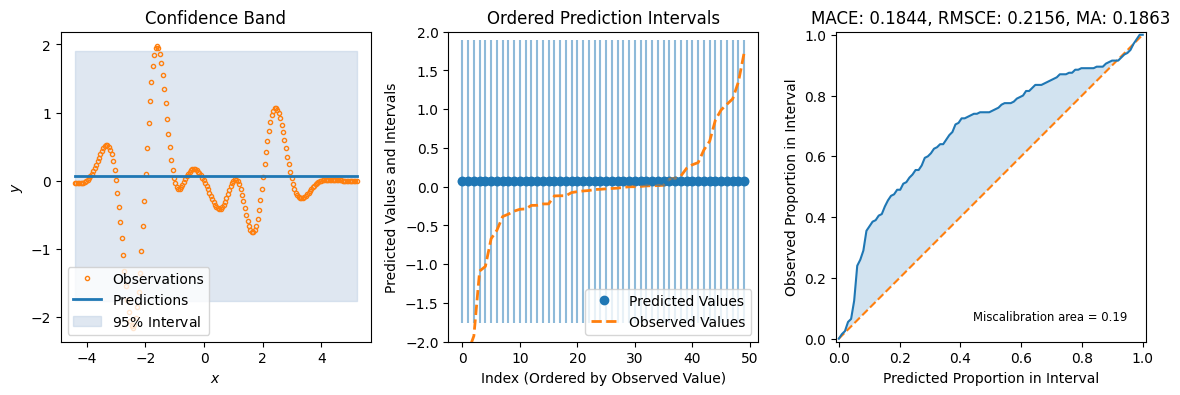

In [29]:
fig = plot_calibration_uq_toolbox(
    preds["mean"], preds["pred_uct"], y_test.cpu().numpy(), X_test.cpu().numpy()
)

## Additional Resources

Links to othere related literature that might be interesting.